In [28]:
#first of all, we import all the packages for Particles, integrators, ic...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from fireworks.nbodylib.integrators import integrator_leapfrog, integrator_leapfrog_galaxy, integrator_rungekutta, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.nbodylib.timesteps import adaptive_timestep_r
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
import time

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [29]:
df_0 = pd.read_csv("data_cvs/Nbody_disc.csv")

# Slicing the dataframe to reduce computation time
num_particles = int(1e3)
df = df_0.iloc[:num_particles]

#I create a class with the mass, pos, vel of each element of the Galaxy
masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]
# reshape mass array to 1D array (required by pyfalcon)
masses = masses.values.reshape(-1)

Galaxy1 = Particles(positions.values, velocities.values, masses)
#I can do the same for the other Galaxy. This second galaxy is the same as the first one, but translated by a certain value. In particular I have
pos_translation = np.array((40., 20., 0.))
vel_translation = np.array((-0.2, 0., 0.))

#So, I just apply this translation to find the second galaxy
positions_gal_2 = positions.values + pos_translation
velocities_gal_2 = velocities.values + vel_translation
Galaxy2 = Particles(positions_gal_2, velocities_gal_2, masses)

# Stability Cheks

In [30]:
def rotation_curve(galaxy: Particles):

    dx = galaxy.pos[:,0] - galaxy.pos[0,0]
    dy = galaxy.pos[:,1] - galaxy.pos[0,1]
    dz = galaxy.pos[:,2] - galaxy.pos[0,2]

    dvx = galaxy.vel[:,0] - galaxy.vel[0,0]
    dvy = galaxy.vel[:,1] - galaxy.vel[0,1]
    dvz = galaxy.vel[:,2] - galaxy.vel[0,2]

    r_cyl   = np.sqrt(dx**2 + dy**2)
    phi     = np.arctan2(dy,dx)
    z       = dz

    v_phi   = dvy * np.cos(phi) - dvx * np.sin(phi)

    return r_cyl, z, v_phi 

In [31]:
def surface_density(Rcyl):
    H, edge = np.histogram(Rcyl, bins=20)                                          # histogram of the cylindrical radius
    area =  np.pi * (edge[1:]**2 - edge[0:-1]**2)                                  # area of every bin (every concentric ring) 
    mid = 0.5 * (edge[1:] + edge[0:-1])                                            # midpoint of every bin  

    return mid, H, area

In [32]:
def integration_leapfrog(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):
    N = len(galaxy.mass)         # number of particles in the galaxy
    path = [galaxy.pos]
    velocity = [galaxy.vel]
    time = []
    timestep = []
 
    Etot_leapfrog = []
    Ekin_leapfrog = []
    Epot_leapfrog = []

    R_cyl, _, vel_phi = rotation_curve(galaxy)

    R_cyl = [R_cyl]
    V_phi = [vel_phi]
    

    while t < tsimulation:
        result = integrator_leapfrog(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        updated_galaxy, _, updated_acc, _, _ = result
        #updated_galaxy.pos -= updated_galaxy.pos[0]  # move the galaxy to the center of mass
        #updated_galaxy.vel -= updated_galaxy.vel[0]
        path.append(updated_galaxy.pos)
        velocity.append(updated_galaxy.vel)
            
        Etot_n, Ekin_n, Epot_n = updated_galaxy.Etot_vett()
        Etot_leapfrog.append(Etot_n)
        Ekin_leapfrog.append(Ekin_n)
        Epot_leapfrog.append(Epot_n)
        
        timestep.append(h)
        t = t + h
        time.append(t)

        
        R , z, V = rotation_curve(updated_galaxy)
        
        timestep.append(h)
        t = t + h
        time.append(t)
        R_cyl.append(R)
        V_phi.append(V)


    path = np.array(path)
    velocity = np.array(velocity)
    time   = np.array(time)
    timestep  = np.array(timestep)

    Etot_leapfrog = np.array(Etot_leapfrog)
    Ekin_leapfrog = np.array(Ekin_leapfrog)
    Etot_leapfrog = np.array(Epot_leapfrog)

    R_cyl       = np.array(R_cyl)
    V_phi       = np.array(V_phi)

    return path, velocity, Etot_leapfrog, Ekin_leapfrog, Epot_leapfrog, time, timestep, R_cyl, V_phi

In [33]:
# compute the orbital period with T = 2*pi*sqrt(a^3/GM)
G = 1.                                                                  # gravitational constant in n-body units
plummer_scale_lenght = 5.                                               # scale lenght of the plummer sphere

central_mass = Galaxy1.mass[0]                                          # central mass of the galaxy

T = 2 * np.pi * np.sqrt(Galaxy1.radius()**3 / (G * central_mass))                   
T = np.mean(T)                                                          # mean period of the galaxy          
#print(f'Average period of the galaxy (approximately): {T}')

# define the time of simulation and the number of steps
t0 = 0.                         # initial time
tsimulation = 1*T               # time of simulation (one period)
N = int(1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps


In [34]:
Galaxy1_test = Galaxy1.copy()

Galaxy1_orbit, Galaxy1_stars_vel, Galaxy1_Etot, Galaxy1_Ekin, Galaxy1_Epot, Galaxy1_time, Galaxy1_timestep, Galaxy1_Rcyl, Galaxy1_Vphi = integration_leapfrog(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

/root/miniconda3/lib/python3.10/site-packages/fireworks-0.0.5-py3.10.egg/fireworks/particles.py:275: RuntimeWarning: divide by zero encountered in divide


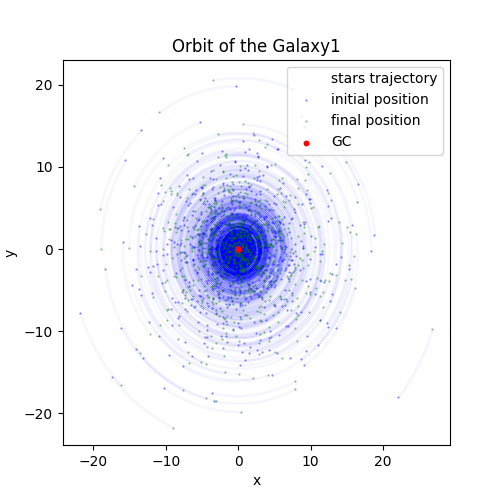

In [35]:
#let us make a plot
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1_orbit[:,1:,0], Galaxy1_orbit[:,1:,1], s=0.05, color='b', label='stars trajectory', alpha=0.01)
plt.plot(Galaxy1_orbit[0,1:,0], Galaxy1_orbit[0,1:,1], 'o', markersize=0.5, c='b', label='initial position', alpha=0.5)
plt.plot(Galaxy1_orbit[-1,1:,0], Galaxy1_orbit[-1,1:,1], 'o', markersize=0.5, c='g', label='final position', alpha=0.5)
plt.scatter(Galaxy1_orbit[:,0,0], Galaxy1_orbit[:,0,1], s=10, color='r', label='GC', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Galaxy1')
plt.legend(loc='upper right')
plt.show()

In [36]:
print(tsimulation)
print(N)
print(len(Galaxy1_Rcyl))
print(len(Galaxy1_Vphi))
print(Galaxy1_Rcyl.shape[0])

104.8239304318399
1000
502
502
502


[  0  50 100 150 200 250 300 350 400 450 500]


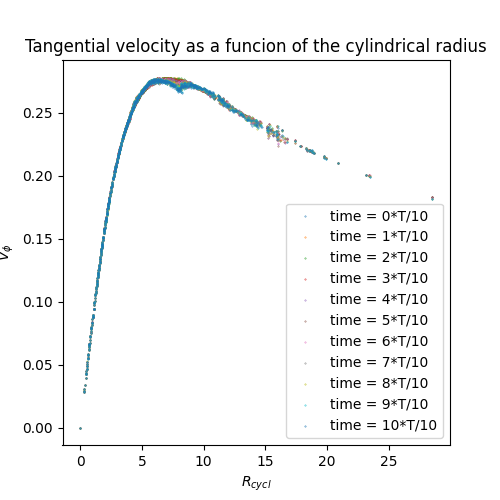

In [37]:
plt.figure(figsize=(5, 5))
n = Galaxy1_Rcyl.shape[0]
snapshots = np.arange(0,int(n), int(n/10))
print(snapshots)
for i in range (len(snapshots)):
    plt.scatter(Galaxy1_Rcyl[snapshots[i],:], Galaxy1_Vphi[snapshots[i],:], s=0.1, label=f'time = {i}*T/10')
    
plt.xlabel('$R_{cycl}$')
plt.ylabel('$V_{\phi}$')
plt.title('Tangential velocity as a funcion of the cylindrical radius')
plt.legend(loc='best')
plt.show()  

# Galaxy 2

In [38]:
Galaxy2_test = Galaxy2.copy()
# Reinitialize all the variables
G = 1.                                                                  # gravitational constant in n-body units
plummer_scale_lenght = 5.                                               # scale lenght of the plummer sphere    
central_mass = Galaxy2.mass[0]                                          # central mass of the galaxy

a = np.sqrt(np.sum((Galaxy2.pos - Galaxy2.pos[0])**2., axis=1))                              # semi-major axis of the galaxy
T = 2 * np.pi * np.sqrt(a**3 / (G * central_mass))
T = np.mean(T)                                                          # mean period of the galaxy
t0 = 0.                         # initial time
tsimulation = 1*T               # time of simulation (one period)
N = int(1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps
print(T)

Galaxy2_orbit, Galaxy2_stars_vel, Galaxy2_Etot, Galaxy2_Ekin, Galaxy2_Epot, Galaxy2_time, Galaxy2_timestep, Galaxy2_Rcyl, Galaxy2_Vphi = integration_leapfrog(galaxy=Galaxy2_test, h=h,
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)
                                                                                            

104.8239304318399


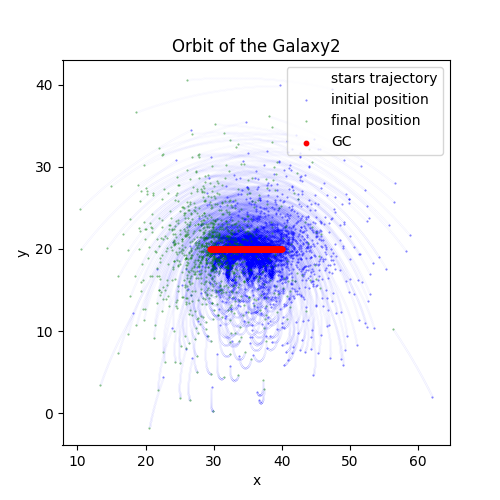

In [39]:
#let us make a plot
plt.figure(figsize=(5,5))
plt.scatter(Galaxy2_orbit[:,1:,0], Galaxy2_orbit[:,1:,1], s=0.05, color='b', label='stars trajectory', alpha=0.01)
plt.plot(Galaxy2_orbit[0,1:,0], Galaxy2_orbit[0,1:,1], 'o', markersize=0.5, c='b', label='initial position', alpha=0.5)
plt.plot(Galaxy2_orbit[-1,1:,0], Galaxy2_orbit[-1,1:,1], 'o', markersize=0.5, c='g', label='final position', alpha=0.5)
plt.scatter(Galaxy2_orbit[:,0,0], Galaxy2_orbit[:,0,1], s=10, color='r', label='GC', zorder=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Galaxy2')
plt.legend(loc='upper right')
plt.show()

[  0  50 100 150 200 250 300 350 400 450 500]


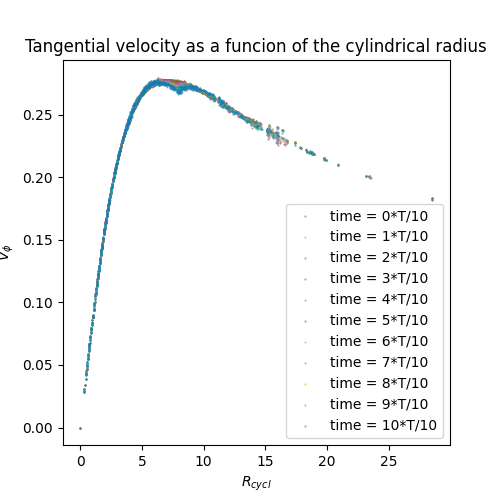

In [40]:
plt.figure(figsize=(5, 5))
n = Galaxy2_Rcyl.shape[0]
snapshots = np.arange(0,int(n), int(n/10))
print(snapshots)
for i in range (len(snapshots)):
    plt.scatter(Galaxy2_Rcyl[snapshots[i],:], Galaxy2_Vphi[snapshots[i],:], s=0.1, label=f'time = {i}*T/10')
    
plt.xlabel('$R_{cycl}$')
plt.ylabel('$V_{\phi}$')
plt.title('Tangential velocity as a funcion of the cylindrical radius')
plt.legend(loc='best')
plt.show() 

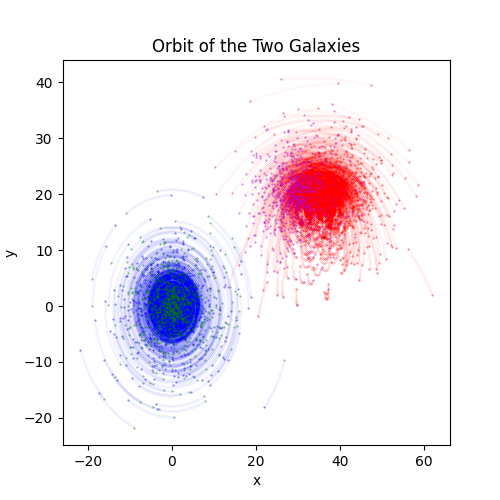

In [41]:
# plot of the two galaxies
plt.figure(figsize=(5, 5))
plt.scatter(Galaxy1_orbit[:,1:,0], Galaxy1_orbit[:,1:,1], s=0.05, color='b', label='Galaxy 1', alpha=0.01)
plt.scatter(Galaxy2_orbit[:,1:,0], Galaxy2_orbit[:,1:,1], s=0.05, color='r', label='Galaxy 2', alpha=0.01)
plt.plot(Galaxy1_orbit[0,1:,0], Galaxy1_orbit[0,1:,1], 'o', markersize=0.5, c='b', label='initial position Galaxy 1', alpha=0.5)
plt.plot(Galaxy1_orbit[-1,1:,0], Galaxy1_orbit[-1,1:,1], 'o', markersize=0.5, c='g', label='final position Galaxy 1', alpha=0.5)
plt.plot(Galaxy2_orbit[0,1:,0], Galaxy2_orbit[0,1:,1], 'o', markersize=0.5, c='r', label='initial position Galaxy 2', alpha=0.5)
plt.plot(Galaxy2_orbit[-1,1:,0], Galaxy2_orbit[-1,1:,1], 'o', markersize=0.5, c='m', label='final position Galaxy 2', alpha=0.5)
plt.scatter(Galaxy1_orbit[:,0,0], Galaxy1_orbit[:,0,1], s=1, color='b', label='Galaxy 1 GC', zorder=10)
plt.scatter(Galaxy2_orbit[:,0,0], Galaxy2_orbit[:,0,1], s=1, color='r', label='Galaxy 2 GC', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Two Galaxies')
#plt.legend(loc='upper right')
plt.show()

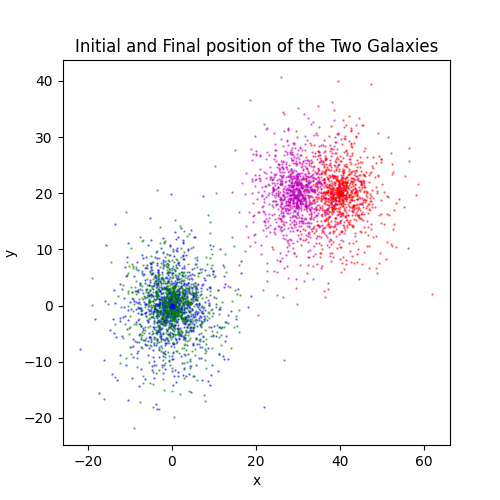

In [42]:
#plot the two galaxies at initial and final position in 2d
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1_orbit[0,1:,0], Galaxy1_orbit[0,1:,1], s=0.5, color='b', label='initial position Galaxy 1', alpha=0.5)
plt.scatter(Galaxy1_orbit[-1,1:,0], Galaxy1_orbit[-1,1:,1], s=0.5, color='g', label='final position Galaxy 1', alpha=0.5)
plt.scatter(Galaxy2_orbit[0,1:,0], Galaxy2_orbit[0,1:,1], s=0.5, color='r', label='initial position Galaxy 2', alpha=0.5)
plt.scatter(Galaxy2_orbit[-1,1:,0], Galaxy2_orbit[-1,1:,1], s=0.5, color='m', label='final position Galaxy 2', alpha=0.5)
plt.scatter(Galaxy1_orbit[0,0,0], Galaxy1_orbit[0,0,1], s=10, color='b', label='Galaxy 1 GC', zorder=10)
plt.scatter(Galaxy2_orbit[0,0,0], Galaxy2_orbit[0,0,1], s=10, color='r', label='Galaxy 2 GC', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Initial and Final position of the Two Galaxies')
#plt.legend(loc='upper right')
plt.show()


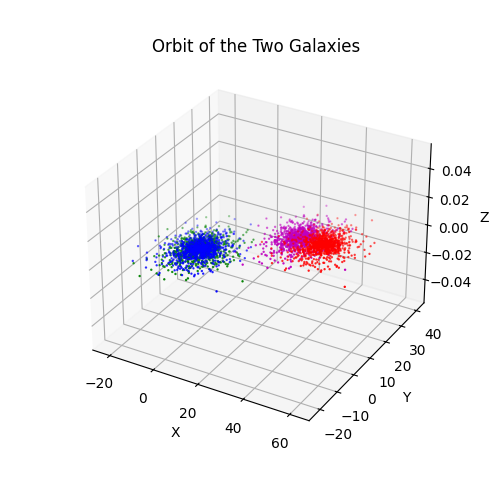

In [43]:
#plot the two galaxies at initial and final position
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Galaxy1_orbit[0,1:,0], Galaxy1_orbit[0,1:,1], Galaxy1_orbit[0,1:,2], s=0.5, c='b', label='initial position Galaxy 1')
ax.scatter(Galaxy1_orbit[-1,1:,0], Galaxy1_orbit[-1,1:,1], Galaxy1_orbit[-1,1:,2], s=0.5, c='g', label='final position Galaxy 1')
ax.scatter(Galaxy2_orbit[0,1:,0], Galaxy2_orbit[0,1:,1], Galaxy2_orbit[0,1:,2], s=0.5, c='r', label='initial position Galaxy 2')
ax.scatter(Galaxy2_orbit[-1,1:,0], Galaxy2_orbit[-1,1:,1], Galaxy2_orbit[-1,1:,2], s=0.5, c='m', label='final position Galaxy 2')
ax.scatter(Galaxy1_orbit[0,0,0], Galaxy1_orbit[0,0,1], Galaxy1_orbit[0,0,2], s=10, c='b', label='Galaxy 1 GC')
ax.scatter(Galaxy1_orbit[-1,0,0], Galaxy1_orbit[-1,0,1], Galaxy1_orbit[-1,0,2], s=10, c='g', label='Galaxy 1 GC')
ax.scatter(Galaxy2_orbit[0,0,0], Galaxy2_orbit[0,0,1], Galaxy2_orbit[0,0,2], s=10, c='r', label='Galaxy 2 GC')
ax.scatter(Galaxy2_orbit[-1,0,0], Galaxy2_orbit[-1,0,1], Galaxy2_orbit[-1,0,2], s=10, c='m', label='Galaxy 2 GC')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Orbit of the Two Galaxies')
#plt.legend(loc='upper right')
plt.show()


# MERGING

In [57]:
# Combine Galaxy1 and Galaxy2 into a single Particles class

num = int(len(Galaxy1.mass))

combined_pos = np.concatenate((Galaxy1.pos, Galaxy2.pos))
combined_vel = np.concatenate((Galaxy1.vel, Galaxy2.vel))
combined_mass = np.concatenate((Galaxy1.mass, Galaxy2.mass))

Combined_Galaxies = Particles(combined_pos, combined_vel, combined_mass)

In [55]:
#evolve the combined galaxy with the leapfrog integrator


# Reinitialize all the variables
t0 = 0.                         # initial time
tsimulation = 210               # time of simulation (one period)
N = int(1e3)                    # number of steps

# just keep the same tsimulation and N as before

Combined_Galaxies_test = Combined_Galaxies.copy()

Combined_Galaxies_orbit, Combined_Galaxies_stars_vel, Combined_Galaxies_Etot, Combined_Galaxies_Ekin, Combined_Galaxies_Epot, Combined_Galaxies_time, Combined_Galaxies_Rcyl, Combined_Galaxies_Vphi, Combined_Galaxies_z = integration_leapfrog(galaxy=Combined_Galaxies_test, h=h, 
                                                                                                                                                                                                                                                tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)




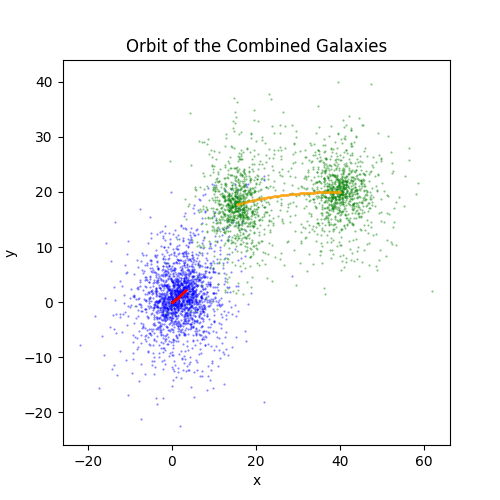

In [58]:
plt.figure(figsize=(5,5))
plt.scatter(Combined_Galaxies_orbit[:,1:num,0], Combined_Galaxies_orbit[:,1:num,1],   s=0.0005, color='lightblue', label='stars trajectory', alpha=0.05)
plt.scatter(Combined_Galaxies_orbit[:,num+1:,0],   Combined_Galaxies_orbit[:,num+1:,1],   s=0.0005, color='lightgreen', label='stars trajectory', alpha=0.05)

plt.plot(Combined_Galaxies_orbit[0,1:num,0],    Combined_Galaxies_orbit[0,1:num,1],     'o', markersize=0.5, c='b', label='initial position of G1', alpha=0.5)
plt.plot(Combined_Galaxies_orbit[-1,1:num,0],   Combined_Galaxies_orbit[-1,1:num,1],    'o', markersize=0.5, c='b', label='final position of G1', alpha=0.5)

plt.plot(Combined_Galaxies_orbit[0,num+1:,0],     Combined_Galaxies_orbit[0,num+1:,1],      'o', markersize=0.5, c='g', label='initial position of G2', alpha=0.5)
plt.plot(Combined_Galaxies_orbit[-1,num+1:,0],    Combined_Galaxies_orbit[-1,num+1:,1],     'o', markersize=0.5, c='g', label='final position of G2', alpha=0.5)

plt.plot(Combined_Galaxies_orbit[0,0,0],     Combined_Galaxies_orbit[0,0,1],            'o', markersize=0.5, color='r', label='initial position of GC 1', zorder=10)
plt.plot(Combined_Galaxies_orbit[-1,0,0],   Combined_Galaxies_orbit[-1,0,1],            'o', markersize=0.5, color='r', label='final position of GC 1', zorder=10)

plt.plot(Combined_Galaxies_orbit[0,num,0],     Combined_Galaxies_orbit[0,num,1],            'o', markersize=0.5, color='orange', label='initial position of GC 1', zorder=10)
plt.plot(Combined_Galaxies_orbit[-1,num,0],   Combined_Galaxies_orbit[-1,num,1],             'o', markersize=0.5, color='orange', label='final position of GC 1', zorder=10)

plt.scatter(Combined_Galaxies_orbit[:,0,0],     Combined_Galaxies_orbit[:,0,1],         s=0.005, color='r', label='GC 1', zorder=10)
plt.scatter(Combined_Galaxies_orbit[:,num,0],   Combined_Galaxies_orbit[:,num,1],     s=0.005, color='orange', label='GC 1', zorder=10)



plt.xlabel('x')
#plt.xlim(-100, 100)
plt.ylabel('y')
#plt.ylim(-100, 100)
plt.title('Orbit of the Combined Galaxies')
#plt.legend(loc='upper right', fontsize=8)
#plt.grid(True, alpha=0.5)
plt.show()

In [87]:
print(num)

1000


# Counterrotating Galaxies

In [73]:
# invert the velocity of the first galaxy

Combined_Galaxies_counter = Combined_Galaxies.copy()
Combined_Galaxies_counter.vel[0:num] = -Combined_Galaxies_counter.vel[0:num]

In [70]:
#evolve the combined galaxy with the leapfrog integrator


# Reinitialize all the variables
t0 = 0.                         # initial time
tsimulation = 210               # time of simulation (one period)
N = int(1e3)                    # number of steps

# just keep the same tsimulation and N as before

Combined_Galaxies_orbit_co, Combined_Galaxies_stars_vel, Combined_Galaxies_Etot, Combined_Galaxies_Ekin, Combined_Galaxies_Epot, Combined_Galaxies_time, Combined_Galaxies_Rcyl, Combined_Galaxies_Vphi, Combined_Galaxies_z = integration_leapfrog(galaxy=Combined_Galaxies_counter, h=h, 
                                                                                                                                                                                                                                                tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)




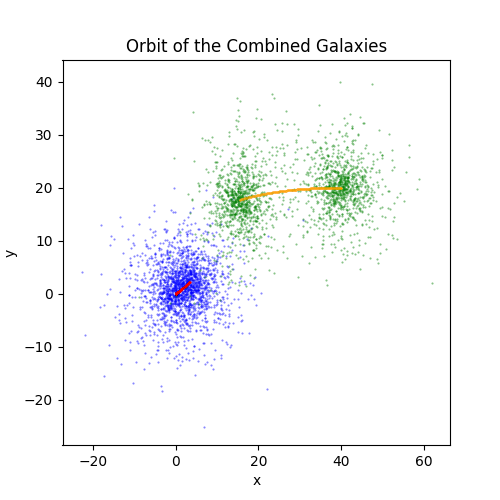

In [71]:
plt.figure(figsize=(5,5))
plt.scatter(Combined_Galaxies_orbit_co[:,1:num,0], Combined_Galaxies_orbit_co[:,1:num,1],   s=0.0005, color='lightblue', label='stars trajectory', alpha=0.05)
plt.scatter(Combined_Galaxies_orbit_co[:,num+1:,0],   Combined_Galaxies_orbit_co[:,num+1:,1],   s=0.0005, color='lightgreen', label='stars trajectory', alpha=0.05)

plt.plot(Combined_Galaxies_orbit_co[0,1:num,0],    Combined_Galaxies_orbit_co[0,1:num,1],     'o', markersize=0.5, c='b', label='initial position of G1', alpha=0.5)
plt.plot(Combined_Galaxies_orbit_co[-1,1:num,0],   Combined_Galaxies_orbit_co[-1,1:num,1],    'o', markersize=0.5, c='b', label='final position of G1', alpha=0.5)

plt.plot(Combined_Galaxies_orbit_co[0,num+1:,0],     Combined_Galaxies_orbit_co[0,num+1:,1],      'o', markersize=0.5, c='g', label='initial position of G2', alpha=0.5)
plt.plot(Combined_Galaxies_orbit_co[-1,num+1:,0],    Combined_Galaxies_orbit_co[-1,num+1:,1],     'o', markersize=0.5, c='g', label='final position of G2', alpha=0.5)

plt.plot(Combined_Galaxies_orbit_co[0,0,0],     Combined_Galaxies_orbit_co[0,0,1],            'o', markersize=0.5, color='r', label='initial position of GC 1', zorder=10)
plt.plot(Combined_Galaxies_orbit_co[-1,0,0],   Combined_Galaxies_orbit_co[-1,0,1],            'o', markersize=0.5, color='r', label='final position of GC 1', zorder=10)

plt.plot(Combined_Galaxies_orbit_co[0,num,0],     Combined_Galaxies_orbit_co[0,num,1],            'o', markersize=0.5, color='orange', label='initial position of GC 1', zorder=10)
plt.plot(Combined_Galaxies_orbit_co[-1,num,0],   Combined_Galaxies_orbit_co[-1,num,1],             'o', markersize=0.5, color='orange', label='final position of GC 1', zorder=10)

plt.scatter(Combined_Galaxies_orbit_co[:,0,0],     Combined_Galaxies_orbit_co[:,0,1],         s=0.005, color='r', label='GC 1', zorder=10)
plt.scatter(Combined_Galaxies_orbit_co[:,num,0],   Combined_Galaxies_orbit_co[:,num,1],     s=0.005, color='orange', label='GC 1', zorder=10)



plt.xlabel('x')
#plt.xlim(-100, 100)
plt.ylabel('y')
#plt.ylim(-100, 100)
plt.title('Orbit of the Combined Galaxies')
#plt.legend(loc='upper right', fontsize=8)
#plt.grid(True, alpha=0.5)
plt.show()

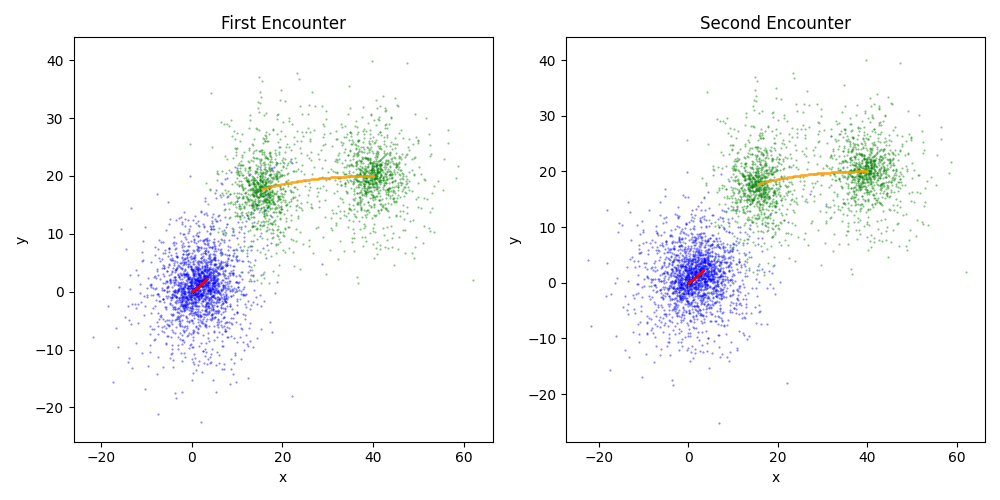

In [72]:
#import matplotlib.pyplot as plt

# First Encounter
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(Combined_Galaxies_orbit[:,1:1000,0], Combined_Galaxies_orbit[:,1:1000,1], s=0.0005, color='lightblue', label='stars trajectory', alpha=0.05)
plt.scatter(Combined_Galaxies_orbit[:,1001:,0], Combined_Galaxies_orbit[:,1001:,1], s=0.0005, color='lightgreen', label='stars trajectory', alpha=0.05)
plt.plot(Combined_Galaxies_orbit[0,1:1000,0], Combined_Galaxies_orbit[0,1:1000,1], 'o', markersize=0.5, c='b', label='initial position of G1', alpha=0.5)
plt.plot(Combined_Galaxies_orbit[-1,1:1000,0], Combined_Galaxies_orbit[-1,1:1000,1], 'o', markersize=0.5, c='b', label='final position of G1', alpha=0.5)
plt.plot(Combined_Galaxies_orbit[0,1001:,0], Combined_Galaxies_orbit[0,1001:,1], 'o', markersize=0.5, c='g', label='initial position of G2', alpha=0.5)
plt.plot(Combined_Galaxies_orbit[-1,1001:,0], Combined_Galaxies_orbit[-1,1001:,1], 'o', markersize=0.5, c='g', label='final position of G2', alpha=0.5)
plt.plot(Combined_Galaxies_orbit[0,0,0], Combined_Galaxies_orbit[0,0,1], 'o', markersize=0.5, color='r', label='initial position of GC 1', zorder=10)
plt.plot(Combined_Galaxies_orbit[-1,0,0], Combined_Galaxies_orbit[-1,0,1], 'o', markersize=0.5, color='r', label='final position of GC 1', zorder=10)
plt.plot(Combined_Galaxies_orbit[0,1000,0], Combined_Galaxies_orbit[0,1000,1], 'o', markersize=0.5, color='orange', label='initial position of GC 1', zorder=10)
plt.plot(Combined_Galaxies_orbit[-1,1000,0], Combined_Galaxies_orbit[-1,1000,1], 'o', markersize=0.5, color='orange', label='final position of GC 1', zorder=10)
plt.scatter(Combined_Galaxies_orbit[:,0,0], Combined_Galaxies_orbit[:,0,1], s=0.005, color='r', label='GC 1', zorder=10)
plt.scatter(Combined_Galaxies_orbit[:,1000,0], Combined_Galaxies_orbit[:,1000,1], s=0.005, color='orange', label='GC 1', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('First Encounter')

# Second Encounter
plt.subplot(1, 2, 2)
plt.scatter(Combined_Galaxies_orbit_co[:,1:1000,0], Combined_Galaxies_orbit_co[:,1:1000,1], s=0.0005, color='lightblue', label='stars trajectory', alpha=0.05)
plt.scatter(Combined_Galaxies_orbit_co[:,1001:,0], Combined_Galaxies_orbit_co[:,1001:,1], s=0.0005, color='lightgreen', label='stars trajectory', alpha=0.05)
plt.plot(Combined_Galaxies_orbit_co[0,1:1000,0], Combined_Galaxies_orbit_co[0,1:1000,1], 'o', markersize=0.5, c='b', label='initial position of G1', alpha=0.5)
plt.plot(Combined_Galaxies_orbit_co[-1,1:1000,0], Combined_Galaxies_orbit_co[-1,1:1000,1], 'o', markersize=0.5, c='b', label='final position of G1', alpha=0.5)
plt.plot(Combined_Galaxies_orbit_co[0,1001:,0], Combined_Galaxies_orbit_co[0,1001:,1], 'o', markersize=0.5, c='g', label='initial position of G2', alpha=0.5)
plt.plot(Combined_Galaxies_orbit_co[-1,1001:,0], Combined_Galaxies_orbit_co[-1,1001:,1], 'o', markersize=0.5, c='g', label='final position of G2', alpha=0.5)
plt.plot(Combined_Galaxies_orbit_co[0,0,0], Combined_Galaxies_orbit_co[0,0,1], 'o', markersize=0.5, color='r', label='initial position of GC 1', zorder=10)
plt.plot(Combined_Galaxies_orbit_co[-1,0,0], Combined_Galaxies_orbit_co[-1,0,1], 'o', markersize=0.5, color='r', label='final position of GC 1', zorder=10)
plt.plot(Combined_Galaxies_orbit_co[0,1000,0], Combined_Galaxies_orbit_co[0,1000,1], 'o', markersize=0.5, color='orange', label='initial position of GC 1', zorder=10)
plt.plot(Combined_Galaxies_orbit_co[-1,1000,0], Combined_Galaxies_orbit_co[-1,1000,1], 'o', markersize=0.5, color='orange', label='final position of GC 1', zorder=10)
plt.scatter(Combined_Galaxies_orbit_co[:,0,0], Combined_Galaxies_orbit_co[:,0,1], s=0.005, color='r', label='GC 1', zorder=10)
plt.scatter(Combined_Galaxies_orbit_co[:,1000,0], Combined_Galaxies_orbit_co[:,1000,1], s=0.005, color='orange', label='GC 1', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Second Encounter')

plt.tight_layout()
plt.show()


# Change of Inclinations

Let us now try to change inclinations. 

# POTENTIAS (TRIAL)

We will now try to add some potentials to our system, in order to make it more realistic. In particular, we implemented three potentials in the 
`potentials` subpackage of the `Fireworks` package. \
These potentials are: 

1) NAVARRO-FRENK-WHITE POTENTIAL (NFW)
This potential is used for the DM halo. \
The formula is the following:
\begin{gather}
    \vec{a} = -\frac{G  M_{\text{vir}}}{r^3 \cdot (a+r)  \delta_c} \left[ (a+r)  \ln\left(1 + \frac{r}{a}\right) - r \right]  \vec{r} \\
    \Phi = -\frac{G M_{\text{vir}} \ln\left(1 + \frac{r}{a}\right)}{r \delta_c}
\end{gather}
The typical values for the constants for the MW galaxy are (from the slides) $M_{vir} = 8 \cdot 10^{11} M_\odot$, $a = 16$ kpc, $c = 15.3$
